데이터 미리보기:
     회차         추첨일  번호1  번호2  번호3  번호4  번호5  번호6  보너스  호기
0  1147  2024.11.24    7   11   24   26   27   37   32   2
1  1146  2024.11.16    6   11   17   19   40   43   28   2
2  1145  2024.11.09    2   11   31   33   37   44   32   2
3  1144  2024.11.02    3    4   12   15   26   34    6   2
4  1143  2024.10.26   10   16   17   27   28   36    6   1
빈도수 분석 결과:
1     158
2     146
3     156
4     152
5     144
6     153
7     157
8     144
9     121
10    153
11    158
12    168
13    165
14    165
15    153
16    153
17    161
18    165
19    158
20    159
21    157
22    135
23    136
24    153
25    140
26    155
27    162
28    142
29    143
30    146
31    155
32    133
33    165
34    177
35    150
36    152
37    160
38    155
39    153
40    163
41    140
42    145
43    158
44    154
45    164
Name: count, dtype: int64
필터링된 후보 번호: [34, 12, 18, 45, 17, 20, 43, 1, 7, 3, 38, 26, 44, 39, 6, 15, 36, 4, 35, 2, 8, 5, 28, 22]
 The best solution found:
 [20. 28.  7. 44.  8. 

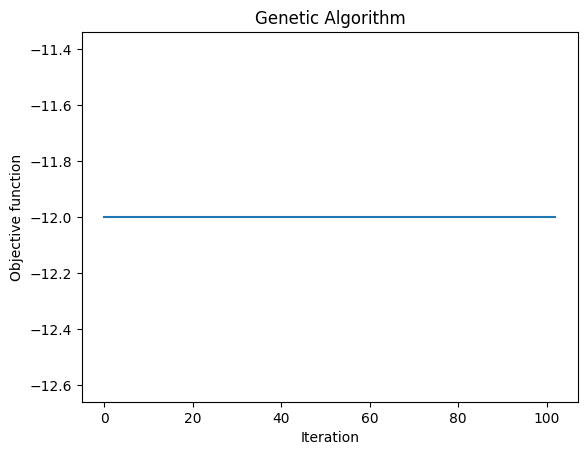


시뮬레이션 성공률: 100.00%


In [4]:

import pandas as pd
from geneticalgorithm import geneticalgorithm as ga
import random

# 실데이터 로드 함수
def load_data_from_url(url):
    """
    주어진 URL에서 CSV 데이터를 로드하고 전처리하여 반환하는 함수.
    """
    data = pd.read_csv(url)
    # 로드한 데이터 확인 (일부만 출력)
    print("데이터 미리보기:")
    print(data.head())

    # 필요한 데이터만 추출 (여기서 '번호1' ~ '번호6' 열이 있다고 가정)
    return data[['번호1', '번호2', '번호3', '번호4', '번호5', '번호6']]

# 번호 빈도수 분석 함수
def analyze_data(data):
    """
    로드된 데이터에서 번호의 빈도수를 분석하여 가장 자주 등장한 번호를 찾는 함수.
    """
    all_numbers = data.values.flatten()
    frequency = pd.Series(all_numbers).value_counts().sort_index()

    print("빈도수 분석 결과:")
#    print(frequency)
    return frequency

# 번호 필터링 함수
def filter_candidates(data, min_frequency=5, exclude_recent=5):
    """
    번호의 빈도수 및 최근 등장한 번호들을 기반으로 필터링된 후보 번호를 반환하는 함수.
    """
    # 빈도수 계산
    all_numbers = data.values.flatten()
    frequency = pd.Series(all_numbers).value_counts()

    # 빈도수가 min_frequency 이상인 번호 필터링
    filtered = frequency[frequency >= min_frequency].index.tolist()

    # 최근 등장한 번호를 제외 (예시로 마지막 5주간 등장한 번호를 제외)
    recent_numbers = data.tail(exclude_recent).values.flatten()
    filtered = [num for num in filtered if num not in recent_numbers]

    print("필터링된 후보 번호:", filtered)
    return filtered

# 적합도 함수 (유전 알고리즘용)
import numpy as np
from geneticalgorithm import geneticalgorithm as ga
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 1. 한글 폰트 설정 함수
def setup_korean_font():
    font_path = None
    for font in font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
        if 'NanumGothic' in font:
            font_path = font
            break

    if font_path:
        font_name = font_manager.FontProperties(fname=font_path).get_name()
        rc('font', family=font_name)
        print(f"한글 폰트 설정 완료: {font_name} ({font_path})")
    else:
        print("한글 폰트가 시스템에 설치되어 있지 않습니다.")

# 2. 적합도 함수
def fitness_function(X, filtered_numbers):
    match_count = np.sum(np.isin(X, filtered_numbers))
    unique_count = len(np.unique(X))
    duplicate_penalty = len(X) - unique_count
    return -(match_count + unique_count - duplicate_penalty)

# 3. 유전 알고리즘 실행 함수
def optimize_combinations(filtered_numbers):
    if not all(1 <= num <= 45 for num in filtered_numbers):
        raise ValueError("filtered_numbers must only contain numbers between 1 and 45")

    min_bound = min(filtered_numbers)
    max_bound = max(filtered_numbers)
    varbound = np.array([[min_bound, max_bound]] * 6)

    algorithm_param = {
        'max_num_iteration': 500,
        'population_size': 100,
        'mutation_probability': 0.2,
        'elit_ratio': 0.01,
        'crossover_probability': 0.8,
        'parents_portion': 0.3,
        'crossover_type': 'one_point',
        'max_iteration_without_improv': 100
    }

    model = ga(
        function=lambda X: fitness_function(X, filtered_numbers),
        dimension=6,
        variable_type='int',
        variable_boundaries=varbound,
        algorithm_parameters=algorithm_param
    )

    np.random.seed(42)
    model.run()

    result = model.output_dict['variable'].astype(int)
    if not all(num in filtered_numbers for num in result):
        raise ValueError("Optimized result contains numbers outside of filtered_numbers")

    return result

# 시뮬레이션 함수
def simulate_combinations(data, combinations):
    """
    생성된 조합들을 시뮬레이션하여 성공 확률을 계산하는 함수.
    """
    all_numbers = data.values.flatten()
    success_count = 0

    for combo in combinations:
        if all(num in all_numbers for num in combo):
            success_count += 1

    success_rate = success_count / len(combinations)
    return success_rate

# 메인 함수
def main():
    # 실데이터 로드
    url = "https://raw.githubusercontent.com/goldapplemango/ai-lotto/refs/heads/main/lotto_data11.csv"
    lotto_data = load_data_from_url(url)

    # 데이터 분석
    frequency = analyze_data(lotto_data)

    # 번호 후보 필터링
    filtered_candidates = filter_candidates(lotto_data)

    # 유전 알고리즘을 통한 최적 조합 생성
    best_combination = optimize_combinations(filtered_candidates)
    print("최적 조합:", best_combination)

    # 시뮬레이션을 통해 성공률 계산
    generated_combinations = [best_combination]
    success_rate = simulate_combinations(lotto_data, generated_combinations)
    print(f"시뮬레이션 성공률: {success_rate * 100:.2f}%")

if __name__ == "__main__":
    main()

In [1]:

!pip install matplotlib pandas geneticalgorithm